<a href="https://colab.research.google.com/github/pren1/VAST/blob/master/Splitter_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# %tensorflow_version 1.x

In [2]:
!rm -rf VAST/
!git clone https://github.com/pren1/VAST.git
!pip3 install soundfile
!pip3 install librosa

Cloning into 'VAST'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 124 (delta 56), reused 58 (delta 21), pack-reused 0
Receiving objects: 100% (124/124), 44.21 MiB | 10.12 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [0]:
from VAST.util import *
import pdb
import pprint
from tqdm import tqdm
import numpy as np
import IPython
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import os
from tqdm import trange

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# adapted from Keith Ito's tacotron implementation
# https://github.com/keithito/tacotron/blob/master/util/audio.py

import librosa
import numpy as np


class Audio():
    def __init__(self):
        self.ref_level_db = 20.0
        self.n_fft = 1200
        self.hop_length = 160
        self.win_length = 400
        self.min_level_db = -100.0

    def wav2spec(self, y):
        D = self.stft(y)
        S = self.amp_to_db(np.abs(D)) - self.ref_level_db
        S, D = self.normalize(S), np.angle(D)
        S, D = S.T, D.T # to make [time, freq]
        return S, D

    def spec2wav(self, spectrogram, phase):
        spectrogram, phase = spectrogram.T, phase.T
        # used during inference only
        # spectrogram: enhanced output
        # phase: use noisy input's phase, so no GLA is required
        S = self.db_to_amp(self.denormalize(spectrogram) + self.ref_level_db)
        return self.istft(S, phase)

    def stft(self, y):
        return librosa.stft(y=y, n_fft=self.n_fft,
                            hop_length=self.hop_length,
                            win_length=self.win_length)

    def istft(self, mag, phase):
        stft_matrix = mag * np.exp(1j*phase)
        return librosa.istft(stft_matrix,
                             hop_length=self.hop_length,
                             win_length=self.win_length)

    def amp_to_db(self, x):
        return 20.0 * np.log10(np.maximum(1e-5, x))

    def db_to_amp(self, x):
        return np.power(10.0, x * 0.05)

    def normalize(self, S):
        return np.clip(S / -self.min_level_db, -1.0, 0.0) + 1.0

    def denormalize(self, S):
        return (np.clip(S, 0.0, 1.0) - 1.0) * -self.min_level_db

audio = Audio()

In [0]:
import math
import tensorflow as tf

def trunk_network(conv_size = 64, LSTM_size = 400, input_size = (51, 601)):
    inputs = tf.keras.layers.Input(input_size)
    x = tf.keras.layers.Reshape((input_size[0],  input_size[1], 1))(inputs)
    # cnn1
    x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (3, 3)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (1, 7))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # cnn2
    x = tf.keras.layers.ZeroPadding2D(padding=((3, 3), (0, 0)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (7, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # # # cnn4
    # x = tf.keras.layers.ZeroPadding2D(padding=((4, 4), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(2, 1))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn5
    # x = tf.keras.layers.ZeroPadding2D(padding=((8, 8), (2, 2)))(x)     
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(4, 1))(x)       
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn6
    # x = tf.keras.layers.ZeroPadding2D(padding=((16, 16), (2, 2)))(x)                 
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(8, 1))(x) 
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn7 TensorShape([None, 51, 601, conv_size])
    # x = tf.keras.layers.ZeroPadding2D(padding=((32, 32), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(16, 1))(x)     
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # cnn8 TensorShape([None, 51, 601, 8])
    x = tf.keras.layers.Conv2D(8, (1, 1))(x)     
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    'Reshape x shape TensorShape([None, 51, 4808])'
    # x = tf.keras.layers.Reshape((tf.keras.backend.int_shape(x)[1], tf.keras.backend.int_shape(x)[2]*tf.keras.backend.int_shape(x)[3]))(x)
    x = tf.keras.layers.Reshape((51, 4808))(x)

    # LSTM 1
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_size, return_sequences=True)
                            )(x)  # [b_s, seq_len, vec_dim]

    # # LSTM 2 TensorShape([None, 51, 800])                                           
    # x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_size, return_sequences=True)
    #                         )(x)  # [b_s, seq_len, vec_dim]

    x = tf.keras.layers.ReLU()(x)
    # Dense 1
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_size[1]))(x)
    x = tf.keras.layers.ReLU()(x)
    # Dense 2
    mask = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_size[1], activation='sigmoid'))(x)

    output = tf.keras.layers.Multiply()([inputs, mask])
    # print(output.shape)
    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    return model

'learning rate decay'
def step_decay(self, epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate    

### Prepare data

In [7]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
with strategy.scope():
  model = trunk_network()
  model.compile(optimizer='adam', loss=['mse'])
  lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

INFO:tensorflow:Initializing the TPU system: grpc://10.0.15.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.15.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 51, 601)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 51, 601, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 51, 607, 1)   0           reshape[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 51, 601, 64)  512         zero_padding2d[0][0]             
______________________________________________________________________________________________

In [0]:
# X_total = []
# y_total = []

# for i in tqdm(range(67)):
#   X_total.append(np.load(f"gdrive/My Drive/Spitter_VTB/mixed_mag/{i}.npy", allow_pickle=True))
#   y_total.append(np.load(f"gdrive/My Drive/Spitter_VTB/target_mag/{i}.npy", allow_pickle=True))

In [10]:
X_total = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/short_mixed_mag_list.npy")
y_total = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/short_target_mag_list.npy")
corresponding_phase = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/short_mixed_phase_list.npy")
X_total.shape

# X_total = np.asarray(X_total).reshape((-1, 51, 601))
# y_total = np.asarray(y_total).reshape((-1, 51, 601))

(10000, 51, 601)

In [0]:
train_ratio = 0.9

In [0]:
X_train = X_total[:int(train_ratio * len(X_total))]
y_train = y_total[:int(train_ratio * len(X_total))]

X_test = X_total[int(train_ratio * len(X_total)):]
y_test = y_total[int(train_ratio * len(X_total)):]
y_phase = corresponding_phase[int(train_ratio * len(X_total)):]

In [0]:
# def generator():
#   while True:
#     yield X_total[0:1], y_total[0:1]

# dataset = tf.data.Dataset.from_generator(generator, output_shapes= ((51, 601), (51, 601)), output_types=((tf.float32, tf.float32)))

In [0]:
# dataset.batch(512)

In [0]:
# model.fit(
#   dataset.batch(32),
#   steps_per_epoch=67,
#   # batch_size = 512,
#   epochs=50,
#   callbacks=[lrate]
# )

In [16]:
# for i in range(3):
#   model.fit(
#   x = X_total, y = y_total,
#   # steps_per_epoch=67,
#   batch_size = 512,
#   epochs=1,
#   # callbacks=[lrate]
#   )

model.fit(
  x = X_train, y = y_train,
  # steps_per_epoch=67,
  batch_size = 512,
  epochs=200,
  callbacks=[lrate]
)

Epoch 1/200
18/18 [==============================] - 57s 3s/step - loss: 0.0267 - lr: 0.0100
Epoch 2/200
18/18 [==============================] - 20s 1s/step - loss: 0.0212 - lr: 0.0100
Epoch 3/200
18/18 [==============================] - 20s 1s/step - loss: 0.0195 - lr: 0.0100
Epoch 4/200
18/18 [==============================] - 20s 1s/step - loss: 0.0188 - lr: 0.0100
Epoch 5/200
18/18 [==============================] - 20s 1s/step - loss: 0.0189 - lr: 0.0100
Epoch 6/200
18/18 [==============================] - 20s 1s/step - loss: 0.0181 - lr: 0.0100
Epoch 7/200
18/18 [==============================] - 20s 1s/step - loss: 0.0176 - lr: 0.0100
Epoch 8/200
18/18 [==============================] - 20s 1s/step - loss: 0.0182 - lr: 0.0100
Epoch 9/200
18/18 [==============================] - 20s 1s/step - loss: 0.0172 - lr: 0.0100
Epoch 10/200
18/18 [==============================] - 20s 1s/step - loss: 0.0167 - lr: 0.0100
Epoch 11/200
18/18 [==============================] - 20s 1s/step - l

In [0]:
model.save('gdrive/My Drive/Spitter_VTB/my_model.h5')

In [0]:
# X_total = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/mixed_mag_list.npy")[-100:]
# y_total = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/target_mag_list.npy")[-100:]
# corresponding_phase = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/mixed_phase_list.npy")[-100:]
# X_total.shape

In [0]:
test_model = tf.keras.models.load_model('gdrive/My Drive/Spitter_VTB/my_model.h5')

In [0]:
# epoch_num = 50
# total_file_length = 67
# iterations = epoch_num * total_file_length

# with trange(iterations) as t:
#   for iteration in t:
#     i = iteration % total_file_length
#     epoch_num = iteration//total_file_length

#     X = X_total[i]
#     y = y_total[i]
#     loss = model.train_on_batch(X[:256, :, :], y[:256, :, :])
#     loss = model.train_on_batch(X[256:, :, :], y[256:, :, :])
#     t.set_description('epo %i [loss: %f]' % (epoch_num, loss))

In [0]:
test_res = test_model.predict(X_train)

In [37]:
test_res.shape

(9000, 51, 601)

In [0]:
def reconstruct_wav(mag, phase, plt_name):
  resulted_wav = audio.spec2wav(mag, phase)
  plt.plot(resulted_wav, color = 'orange', label='resulted_wav')
  plt.title(plt_name)
  plt.show()
  IPython.display.display(IPython.display.Audio(np.asarray(resulted_wav).T, rate=8000))

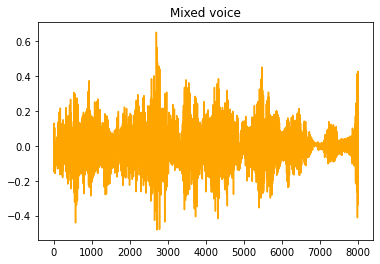

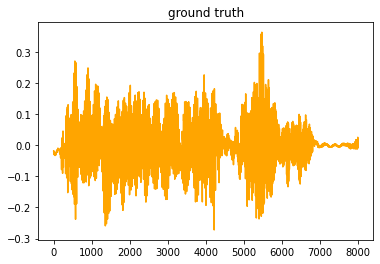

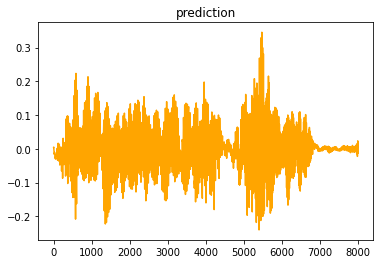

In [41]:
for i in range(1):
  i = 20
  reconstruct_wav(X_train[i], y_phase[i], "Mixed voice")
  reconstruct_wav(y_train[i], y_phase[i], "ground truth")
  reconstruct_wav(test_res[i], y_phase[i], "prediction")